# Neural networks

### Libraries


In [96]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import keras
import os

import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import make_pipeline, Pipeline 
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.combine import SMOTEENN

import time
from skopt import BayesSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import shap


### Functions

In [102]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, batch_size=64, verbose=1)
    y_pred_bool = from_probs_to_class(y_pred, threshold=0.5)
    print(classification_report(y_test, y_pred_bool))
    print("fscore on test set: ", f1_score(y_test, y_pred_bool, zero_division=True))
    print("AUC score:", roc_auc_score(y_test, y_pred_bool))
    print("confusion matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bool)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.title("Confusion matrix", fontsize=10)
    plt.show()

### Importing data

In [3]:
# Read the two datasets from the pickle files
dir_path = os.getcwd()

X_tr = pd.read_pickle(dir_path + "\\data\\X_train_log.pkl")
X_te = pd.read_pickle(dir_path + "\\data\\X_test_log.pkl")


y_train = pd.read_pickle(dir_path + "\\data\\y_train.pkl")
y_test = pd.read_pickle(dir_path + "\\data\\y_test.pkl")

X_test_not_scaled = pd.read_pickle(dir_path + "\\data\\X_test.pkl")



LIMIT_BAL  SEX_MALE  AGE  PAY_9  PAY_8  PAY_7  PAY_6  PAY_5  PAY_4  \
2308       30000         1   25      0      0      0      0      0      0   
22404     150000         0   26      0      0      0      0      0      0   
23397      70000         0   32      0      0      0      0      0      0   
25058     130000         1   49      0      0      0      0      0     -1   
2664       50000         0   36      0      0      0      0      0      2   
...          ...       ...  ...    ...    ...    ...    ...    ...    ...   
3211       40000         0   49      1     -2     -2     -2     -2     -1   
9355      330000         0   42      0      0      0      0      0      0   
28201     300000         0   48      1      3      2     -1      0     -1   
19705     100000         0   47     -1     -1     -1     -1     -1     -2   
28313     120000         0   34     -2     -1     -1     -1     -1     -2   

       BILL_AMT_9  ...  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
2308         8864  ...            0            1            0            0   
22404      136736  ...            1            0            0            0   
23397       70122  ...            0            0            1            0   
25058       20678  ...            0            0            1            0   
2664        94228  ...            0            1            0            0   
...           ...  ...          ...          ...          ...          ...   
3211            0  ...            0            0            1            0   
9355        18516  ...            0            1            0            0   
28201          -2  ...            0            0            1            0   
19705        6666  ...            0            1            0            0   
28313           0  ...            0            0            1            0   

       EDUCATION_5  EDUCATION_6  MARRIAGE_0  MARRIAGE_1  MARRIAGE_2  \
2308             0            0           0           0           1   
22404            0            0           0           0           1   
23397            0            0           0           1           0   
25058            0            0           0           0           1   
2664             0            0           0           0           1   
...            ...          ...         ...         ...         ...   
3211             0            0           0           1           0   
9355             0            0           0           1           0   
28201            0            0           0           0           1   
19705            0            0           0           1           0   
28313            0            0           0           1           0   

       MARRIAGE_3  
2308            0  
22404           0  
23397           0  
25058           0  
2664            0  
...           ...  
3211            0  
9355            0  
28201           0  
19705           0  
28313           0  

[7500 rows x 32 columns]

### Normalizing the data

In [4]:
columns = X_tr.columns

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_tr), columns= columns)
X_test = pd.DataFrame (scaler.transform(X_te), columns= columns)


#### inizializations


In [5]:
model_names = []
model_instances = []
model_scores = []

In [6]:
n_iter = 80
epochs = 7
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## GridsearchCV with RandomUndersampling a NN (one hidden layer)


In [7]:
# nn base function
def create_nn_model(n_neurons_1=40, learning_rate=0.001):
    model = keras.models.Sequential([
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


In [8]:


model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Parameters
n_neurons = [4, 8, 16, 32, 64, 124, 248, 372, 496, 744, 992, 1488, 1984]

# Pipeline
smote_pipe_nn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons)
grid = RandomizedSearchCV(smote_pipe_nn, param_distributions=param_grid, cv = cv,  n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_0 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_0.best_params_)
print("f1 score:", grid_result_nn_0.best_score_)


model_names.append("nn_ru_simple")
model_instances.append(grid_result_nn_0.best_estimator_)
model_scores.append(grid_result_nn_0.best_score_)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
The total space of parameters 13 is smaller than n_iter=80. Running 13 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Process time: 80.79873776435852
Best parameters: {'model__n_neurons_1': 248}
f1 score: 0.5224065929967003


## GridsearchCV with RandomUndersampling a NN

In [9]:
# nn base function
def create_nn_model(n_neurons_1=40, n_neurons_2=20, dropout=0.1, learning_rate=0.001):
    model = keras.models.Sequential([
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(n_neurons_2,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


In [10]:
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameters
n_neurons = [2, 4, 8, 16, 32, 64, 124, 248, 372, 496, 744, 992, 1488]


# Pipeline
smote_pipe_nn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons)
grid = RandomizedSearchCV(smote_pipe_nn, param_distributions=param_grid, cv = cv,  n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_1 = grid.fit(X_train, y_train)

end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_1.best_params_)
print("f1 score:", grid_result_nn_1.best_score_)


model_names.append("nn_ru")                                                                                                                                                                                                                                                      
model_instances.append(grid_result_nn_1.best_estimator_)
model_scores.append(grid_result_nn_1.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Process time: 1527.2010869979858
Best parameters: {'model__n_neurons_2': 16, 'model__n_neurons_1': 1488}
f1 score: 0.5304823904611069


## GridsearchCV with class weights on a NN

In [11]:
value_counts = y_train.value_counts()
tot = len(y_train)
min_prop = round(value_counts[1]/tot, 3)
print("The proportion of the minority class on the train_set is", min_prop)

The proportion of the minority class on the train_set is 0.223


In [12]:
class_weight = {0: min_prop, 1: 1-min_prop}
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# GridsearchCV
param_grid = dict(n_neurons_1=n_neurons, n_neurons_2=n_neurons)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_2 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_2.best_params_)
print("f1 score:", grid_result_nn_2.best_score_)

model_names.append("nn_classweights")
model_instances.append(grid_result_nn_2.best_estimator_)
model_scores.append(grid_result_nn_2.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 4392.907832622528
Best parameters: {'n_neurons_2': 496, 'n_neurons_1': 124}
f1 score: 0.5410550901186175


## Gridsearchcv with RandomUndersampling and CNN

In [13]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



In [14]:
model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]
# learning_rates = [0.1, 0.01, 0.001]

# Pipeline
smote_pipe_cnn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_filters_1=n_filters, model__n_filters_2=n_filters, model__n_kernels_1=n_kernels, model__n_kernels_2=n_kernels)
grid = RandomizedSearchCV(smote_pipe_cnn, cv = cv, param_distributions=param_grid, n_iter=n_iter, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_1 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_1.best_params_)
print("f1 score:", grid_result_cnn_1.best_score_)

model_names.append("cnn_randomunder")
model_instances.append(grid_result_cnn_1.best_estimator_)
model_scores.append(grid_result_cnn_1.best_score_)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 990.8588535785675
Best parameters: {'model__n_kernels_2': 8, 'model__n_kernels_1': 16, 'model__n_filters_2': 32, 'model__n_filters_1': 16}
f1 score: 0.5305395883755702


## Gridsearchcv with class weights and cnn

In [15]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



In [16]:
class_weight = {0: min_prop, 1: 1-min_prop}

model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]



# GridsearchCV
param_grid = dict(n_filters_1=n_filters, n_filters_2=n_filters, n_kernels_1=n_kernels, n_kernels_2=n_kernels)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_2 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_2.best_params_)
print("f1 score:", grid_result_cnn_2.best_score_)

model_names.append("cnn_classweights")
model_instances.append(grid_result_cnn_2.best_estimator_)
model_scores.append(grid_result_cnn_2.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 1732.3997039794922
Best parameters: {'n_kernels_2': 4, 'n_kernels_1': 16, 'n_filters_2': 128, 'n_filters_1': 128}
f1 score: 0.5369457320110392


## Gridsearchcv with class weight on CNN with dense layers

In [17]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01, n_neurons_1=10, n_neurons_2=10):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(n_neurons_2,activation="relu"),

    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model


In [18]:
class_weight = {0: min_prop, 1: 1-min_prop}

model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]
n_neurons = [2, 4, 8, 16, 32, 64, 248, 496, 992]


# GridsearchCV
param_grid = dict(n_filters_1=n_filters, n_filters_2=n_filters, n_kernels_1=n_kernels, n_kernels_2=n_kernels, n_neurons_1=n_neurons,  n_neurons_2=n_neurons)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_3 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_3.best_params_)
print("f1 score:", grid_result_cnn_3.best_score_)

model_names.append("cnn_classweights_with_dense")
model_instances.append(grid_result_cnn_3.best_estimator_)
model_scores.append(grid_result_cnn_3.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 3088.280990600586
Best parameters: {'n_neurons_2': 32, 'n_neurons_1': 32, 'n_kernels_2': 16, 'n_kernels_1': 16, 'n_filters_2': 4, 'n_filters_1': 2}
f1 score: 0.5285701051929831


### Printing results

In [82]:
models_df = pd.DataFrame({"Model name": model_names, "f1 score on validation": model_scores}) 

In [83]:
models_df

Model name  f1 score on validation
0                 nn_ru_simple                0.522407
1                        nn_ru                0.530482
2              nn_classweights                0.541055
3              cnn_randomunder                0.530540
4             cnn_classweights                0.536946
5  cnn_classweights_with_dense                0.528570

In [84]:
# best model nn_class_weights
final_model = model_instances[2]

118/118 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      5873
           1       0.43      0.63      0.51      1627

    accuracy                           0.74      7500
   macro avg       0.66      0.70      0.67      7500
weighted avg       0.78      0.74      0.76      7500

fscore on test set:  0.5129624968537629
AUC score: 0.700178412748181
confusion matrix:


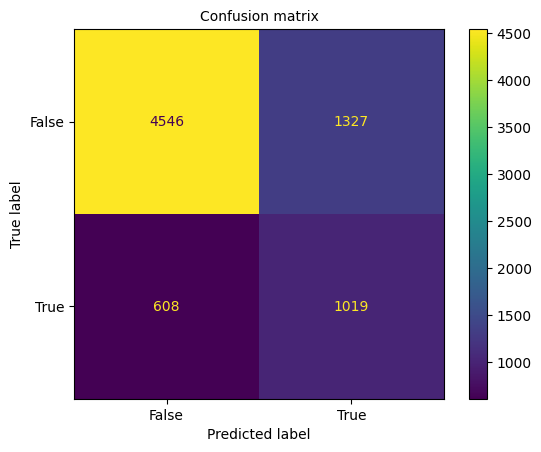

In [103]:
evaluate_model(final_model, X_test, y_test)

## SHAP

In [74]:
samples_to_analyze = 100

In [119]:
# creating dataframe with wrong prediction in case to analyze
preds = final_model.predict(X_test).reshape(7500)

235/235 [==============================] - 2s 10ms/step


In [123]:
row_selected = np.where((preds == 1) & (y_test == 0) == True)[0][0]

In [137]:
X_test_not_scaled.iloc[row_selected]

LIMIT_BAL      140000
SEX_MALE            0
AGE                32
PAY_9               1
PAY_8              -2
PAY_7              -2
PAY_6              -2
PAY_5              -2
PAY_4              -2
BILL_AMT_9          0
BILL_AMT_8          0
BILL_AMT_7          0
BILL_AMT_6          0
BILL_AMT_5          0
BILL_AMT_4          0
PAY_AMT_9           0
PAY_AMT_8           0
PAY_AMT_7           0
PAY_AMT_6           0
PAY_AMT_5           0
PAY_AMT_4           0
EDUCATION_0         0
EDUCATION_1         1
EDUCATION_2         0
EDUCATION_3         0
EDUCATION_4         0
EDUCATION_5         0
EDUCATION_6         0
MARRIAGE_0          0
MARRIAGE_1          1
MARRIAGE_2          0
MARRIAGE_3          0
Name: 7790, dtype: int64

In [87]:
# creating explainer object
explainer = shap.Explainer(final_model.predict, X_test[:samples_to_analyze], verbose= False)

In [88]:
# calculating shap values
shap_values = explainer(X_test[:samples_to_analyze])

124/124 [==============================] - 1s 8ms/step


Permutation explainer:   1%|▋                                                                  | 1/100 [00:00<?, ?it/s]

84/84 [==============================] - 1s 10ms/step


Permutation explainer:   3%|█▊                                                         | 3/100 [00:23<10:29,  6.49s/it]

83/83 [==============================] - 1s 9ms/step


Permutation explainer:   4%|██▎                                                        | 4/100 [00:35<14:22,  8.99s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:   5%|██▉                                                        | 5/100 [00:48<16:20, 10.32s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:   6%|███▌                                                       | 6/100 [01:00<17:07, 10.94s/it]

83/83 [==============================] - 1s 10ms/step


Permutation explainer:   7%|████▏                                                      | 7/100 [01:12<17:40, 11.41s/it]

83/83 [==============================] - 1s 10ms/step


Permutation explainer:   8%|████▋                                                      | 8/100 [01:25<17:56, 11.70s/it]

84/84 [==============================] - 1s 10ms/step


Permutation explainer:   9%|█████▎                                                     | 9/100 [01:37<18:15, 12.04s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:  10%|█████▊                                                    | 10/100 [01:51<18:33, 12.37s/it]

80/80 [==============================] - 1s 10ms/step


Permutation explainer:  11%|██████▍                                                   | 11/100 [02:03<18:18, 12.35s/it]

86/86 [==============================] - 1s 11ms/step


Permutation explainer:  12%|██████▉                                                   | 12/100 [02:16<18:34, 12.67s/it]

88/88 [==============================] - 1s 9ms/step


Permutation explainer:  13%|███████▌                                                  | 13/100 [02:29<18:21, 12.66s/it]

82/82 [==============================] - 1s 8ms/step


Permutation explainer:  14%|████████                                                  | 14/100 [02:40<17:35, 12.27s/it]

88/88 [==============================] - 1s 8ms/step


Permutation explainer:  15%|████████▋                                                 | 15/100 [02:52<17:19, 12.23s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  16%|█████████▎                                                | 16/100 [03:04<17:01, 12.16s/it]

82/82 [==============================] - 1s 8ms/step


Permutation explainer:  17%|█████████▊                                                | 17/100 [03:16<16:28, 11.91s/it]

85/85 [==============================] - 1s 8ms/step


Permutation explainer:  18%|██████████▍                                               | 18/100 [03:27<16:12, 11.86s/it]

86/86 [==============================] - 1s 8ms/step


Permutation explainer:  19%|███████████                                               | 19/100 [03:39<15:43, 11.64s/it]

85/85 [==============================] - 1s 8ms/step


Permutation explainer:  20%|███████████▌                                              | 20/100 [03:51<15:55, 11.94s/it]

86/86 [==============================] - 1s 7ms/step


Permutation explainer:  21%|████████████▏                                             | 21/100 [04:04<15:52, 12.06s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  22%|████████████▊                                             | 22/100 [04:15<15:34, 11.98s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  23%|█████████████▎                                            | 23/100 [04:28<15:25, 12.02s/it]

79/79 [==============================] - 1s 9ms/step


Permutation explainer:  24%|█████████████▉                                            | 24/100 [04:39<14:51, 11.72s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  25%|██████████████▌                                           | 25/100 [04:50<14:30, 11.61s/it]

82/82 [==============================] - 1s 8ms/step


Permutation explainer:  26%|███████████████                                           | 26/100 [05:01<14:17, 11.59s/it]

88/88 [==============================] - 1s 8ms/step


Permutation explainer:  27%|███████████████▋                                          | 27/100 [05:13<14:13, 11.69s/it]

90/90 [==============================] - 1s 8ms/step


Permutation explainer:  28%|████████████████▏                                         | 28/100 [05:26<14:31, 12.10s/it]

88/88 [==============================] - 1s 6ms/step


Permutation explainer:  29%|████████████████▊                                         | 29/100 [05:37<13:50, 11.70s/it]

89/89 [==============================] - 1s 6ms/step


Permutation explainer:  30%|█████████████████▍                                        | 30/100 [05:47<13:05, 11.22s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  31%|█████████████████▉                                        | 31/100 [05:58<12:52, 11.20s/it]

85/85 [==============================] - 1s 7ms/step


Permutation explainer:  32%|██████████████████▌                                       | 32/100 [06:09<12:31, 11.05s/it]

85/85 [==============================] - 1s 7ms/step


Permutation explainer:  33%|███████████████████▏                                      | 33/100 [06:20<12:11, 10.92s/it]

87/87 [==============================] - 1s 6ms/step


Permutation explainer:  34%|███████████████████▋                                      | 34/100 [06:30<11:50, 10.76s/it]

81/81 [==============================] - 1s 8ms/step


Permutation explainer:  35%|████████████████████▎                                     | 35/100 [06:40<11:12, 10.35s/it]

84/84 [==============================] - 1s 8ms/step


Permutation explainer:  36%|████████████████████▉                                     | 36/100 [06:50<11:00, 10.32s/it]

83/83 [==============================] - 1s 8ms/step


Permutation explainer:  37%|█████████████████████▍                                    | 37/100 [07:00<10:45, 10.25s/it]

87/87 [==============================] - 1s 9ms/step


Permutation explainer:  38%|██████████████████████                                    | 38/100 [07:10<10:41, 10.34s/it]

88/88 [==============================] - 1s 8ms/step


Permutation explainer:  39%|██████████████████████▌                                   | 39/100 [07:24<11:37, 11.43s/it]

81/81 [==============================] - 1s 7ms/step


Permutation explainer:  40%|███████████████████████▏                                  | 40/100 [07:36<11:22, 11.37s/it]

81/81 [==============================] - 1s 7ms/step


Permutation explainer:  41%|███████████████████████▊                                  | 41/100 [07:47<11:04, 11.26s/it]

78/78 [==============================] - 1s 6ms/step


Permutation explainer:  42%|████████████████████████▎                                 | 42/100 [07:57<10:44, 11.11s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:  43%|████████████████████████▉                                 | 43/100 [08:10<10:55, 11.50s/it]

84/84 [==============================] - 1s 8ms/step


Permutation explainer:  44%|█████████████████████████▌                                | 44/100 [08:22<11:01, 11.81s/it]

83/83 [==============================] - 1s 8ms/step


Permutation explainer:  45%|██████████████████████████                                | 45/100 [08:34<10:49, 11.80s/it]

87/87 [==============================] - 1s 8ms/step


Permutation explainer:  46%|██████████████████████████▋                               | 46/100 [08:47<10:47, 12.00s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  47%|███████████████████████████▎                              | 47/100 [08:58<10:19, 11.69s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  48%|███████████████████████████▊                              | 48/100 [09:09<10:05, 11.65s/it]

81/81 [==============================] - 1s 8ms/step


Permutation explainer:  49%|████████████████████████████▍                             | 49/100 [09:19<09:35, 11.28s/it]

83/83 [==============================] - 1s 9ms/step


Permutation explainer:  50%|█████████████████████████████                             | 50/100 [09:31<09:28, 11.36s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  51%|█████████████████████████████▌                            | 51/100 [09:43<09:20, 11.44s/it]

82/82 [==============================] - 1s 8ms/step


Permutation explainer:  52%|██████████████████████████████▏                           | 52/100 [09:55<09:16, 11.59s/it]

88/88 [==============================] - 1s 8ms/step


Permutation explainer:  53%|██████████████████████████████▋                           | 53/100 [10:07<09:18, 11.89s/it]

83/83 [==============================] - 1s 9ms/step


Permutation explainer:  54%|███████████████████████████████▎                          | 54/100 [10:18<08:58, 11.70s/it]

82/82 [==============================] - 1s 9ms/step


Permutation explainer:  55%|███████████████████████████████▉                          | 55/100 [10:30<08:39, 11.55s/it]

88/88 [==============================] - 1s 7ms/step


Permutation explainer:  56%|████████████████████████████████▍                         | 56/100 [10:42<08:40, 11.84s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  57%|█████████████████████████████████                         | 57/100 [10:53<08:20, 11.65s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  58%|█████████████████████████████████▋                        | 58/100 [11:04<07:54, 11.29s/it]

87/87 [==============================] - 1s 8ms/step


Permutation explainer:  59%|██████████████████████████████████▏                       | 59/100 [11:17<08:01, 11.75s/it]

88/88 [==============================] - 1s 7ms/step


Permutation explainer:  60%|██████████████████████████████████▊                       | 60/100 [11:28<07:49, 11.75s/it]

80/80 [==============================] - 1s 9ms/step


Permutation explainer:  61%|███████████████████████████████████▍                      | 61/100 [11:39<07:21, 11.33s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:  62%|███████████████████████████████████▉                      | 62/100 [11:52<07:28, 11.80s/it]

89/89 [==============================] - 1s 7ms/step


Permutation explainer:  63%|████████████████████████████████████▌                     | 63/100 [12:04<07:23, 11.99s/it]

86/86 [==============================] - 1s 6ms/step


Permutation explainer:  64%|█████████████████████████████████████                     | 64/100 [12:15<06:59, 11.65s/it]

84/84 [==============================] - 1s 8ms/step


Permutation explainer:  65%|█████████████████████████████████████▋                    | 65/100 [12:25<06:31, 11.18s/it]

83/83 [==============================] - 1s 7ms/step


Permutation explainer:  66%|██████████████████████████████████████▎                   | 66/100 [12:36<06:13, 10.99s/it]

88/88 [==============================] - 1s 7ms/step


Permutation explainer:  67%|██████████████████████████████████████▊                   | 67/100 [12:46<05:57, 10.84s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  68%|███████████████████████████████████████▍                  | 68/100 [12:56<05:42, 10.70s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  69%|████████████████████████████████████████                  | 69/100 [13:08<05:35, 10.83s/it]

81/81 [==============================] - 1s 8ms/step


Permutation explainer:  70%|████████████████████████████████████████▌                 | 70/100 [13:18<05:25, 10.84s/it]

84/84 [==============================] - 1s 9ms/step


Permutation explainer:  71%|█████████████████████████████████████████▏                | 71/100 [13:29<05:13, 10.82s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  72%|█████████████████████████████████████████▊                | 72/100 [13:40<05:01, 10.78s/it]

86/86 [==============================] - 1s 7ms/step


Permutation explainer:  73%|██████████████████████████████████████████▎               | 73/100 [13:52<04:58, 11.06s/it]

83/83 [==============================] - 1s 7ms/step


Permutation explainer:  74%|██████████████████████████████████████████▉               | 74/100 [14:03<04:52, 11.27s/it]

80/80 [==============================] - 1s 8ms/step


Permutation explainer:  75%|███████████████████████████████████████████▌              | 75/100 [14:14<04:36, 11.07s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  76%|████████████████████████████████████████████              | 76/100 [14:25<04:26, 11.09s/it]

85/85 [==============================] - 1s 8ms/step


Permutation explainer:  77%|████████████████████████████████████████████▋             | 77/100 [14:36<04:15, 11.09s/it]

80/80 [==============================] - 1s 9ms/step


Permutation explainer:  78%|█████████████████████████████████████████████▏            | 78/100 [14:47<04:01, 10.98s/it]

87/87 [==============================] - 1s 8ms/step


Permutation explainer:  79%|█████████████████████████████████████████████▊            | 79/100 [14:59<03:58, 11.37s/it]

81/81 [==============================] - 1s 7ms/step


Permutation explainer:  80%|██████████████████████████████████████████████▍           | 80/100 [15:11<03:47, 11.37s/it]

87/87 [==============================] - 1s 7ms/step


Permutation explainer:  81%|██████████████████████████████████████████████▉           | 81/100 [15:20<03:27, 10.92s/it]

84/84 [==============================] - 1s 10ms/step


Permutation explainer:  82%|███████████████████████████████████████████████▌          | 82/100 [15:33<03:25, 11.40s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:  83%|████████████████████████████████████████████████▏         | 83/100 [15:44<03:10, 11.20s/it]

80/80 [==============================] - 1s 10ms/step


Permutation explainer:  84%|████████████████████████████████████████████████▋         | 84/100 [15:55<02:58, 11.17s/it]

85/85 [==============================] - 1s 8ms/step


Permutation explainer:  85%|█████████████████████████████████████████████████▎        | 85/100 [16:07<02:52, 11.50s/it]

86/86 [==============================] - 1s 9ms/step


Permutation explainer:  86%|█████████████████████████████████████████████████▉        | 86/100 [16:19<02:43, 11.67s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  87%|██████████████████████████████████████████████████▍       | 87/100 [16:30<02:28, 11.41s/it]

86/86 [==============================] - 1s 7ms/step


Permutation explainer:  88%|███████████████████████████████████████████████████       | 88/100 [16:41<02:16, 11.35s/it]

85/85 [==============================] - 1s 7ms/step


Permutation explainer:  89%|███████████████████████████████████████████████████▌      | 89/100 [16:51<01:59, 10.85s/it]

81/81 [==============================] - 1s 8ms/step


Permutation explainer:  90%|████████████████████████████████████████████████████▏     | 90/100 [17:01<01:47, 10.77s/it]

80/80 [==============================] - 1s 9ms/step


Permutation explainer:  91%|████████████████████████████████████████████████████▊     | 91/100 [17:14<01:42, 11.36s/it]

83/83 [==============================] - 1s 8ms/step


Permutation explainer:  92%|█████████████████████████████████████████████████████▎    | 92/100 [17:26<01:32, 11.50s/it]

79/79 [==============================] - 1s 9ms/step


Permutation explainer:  93%|█████████████████████████████████████████████████████▉    | 93/100 [17:37<01:19, 11.32s/it]

82/82 [==============================] - 1s 8ms/step


Permutation explainer:  94%|██████████████████████████████████████████████████████▌   | 94/100 [17:49<01:09, 11.62s/it]

85/85 [==============================] - 1s 7ms/step


Permutation explainer:  95%|███████████████████████████████████████████████████████   | 95/100 [18:00<00:57, 11.52s/it]

89/89 [==============================] - 1s 9ms/step


Permutation explainer:  96%|███████████████████████████████████████████████████████▋  | 96/100 [18:13<00:46, 11.70s/it]

84/84 [==============================] - 1s 7ms/step


Permutation explainer:  97%|████████████████████████████████████████████████████████▎ | 97/100 [18:23<00:34, 11.34s/it]

84/84 [==============================] - 1s 8ms/step


Permutation explainer:  98%|████████████████████████████████████████████████████████▊ | 98/100 [18:35<00:23, 11.58s/it]

81/81 [==============================] - 1s 9ms/step


Permutation explainer:  99%|█████████████████████████████████████████████████████████▍| 99/100 [18:48<00:11, 11.84s/it]

83/83 [==============================] - 1s 7ms/step


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [18:59<00:00, 11.75s/it]

86/86 [==============================] - 1s 8ms/step


Permutation explainer: 101it [19:10, 11.51s/it]                                                                        


####  local explanation 

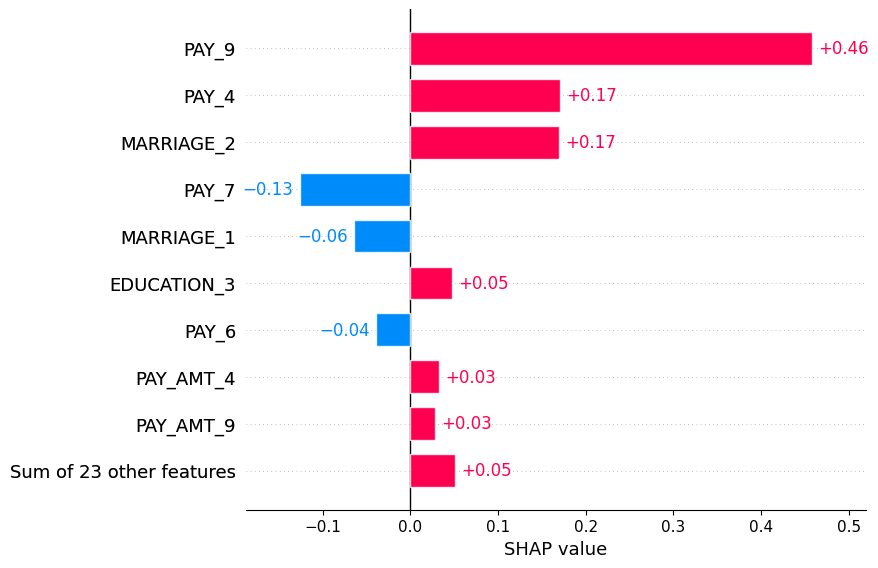

In [129]:
shap.plots.bar(shap_values[row_selected])

#### global explanation 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


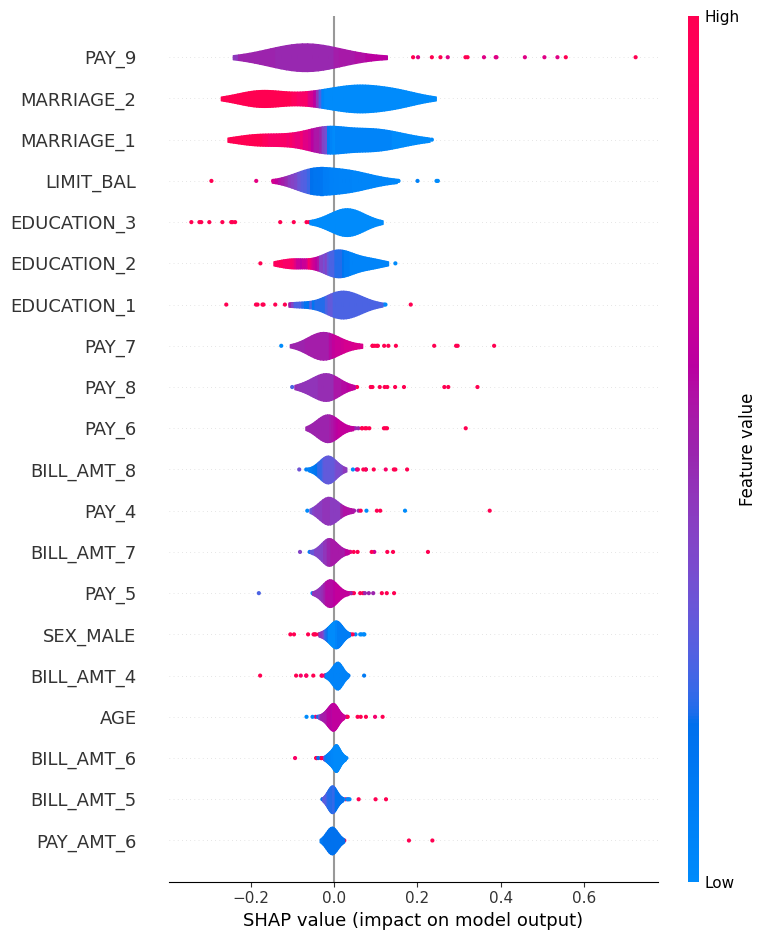

In [130]:
shap.summary_plot(shap_values, plot_type='violin')

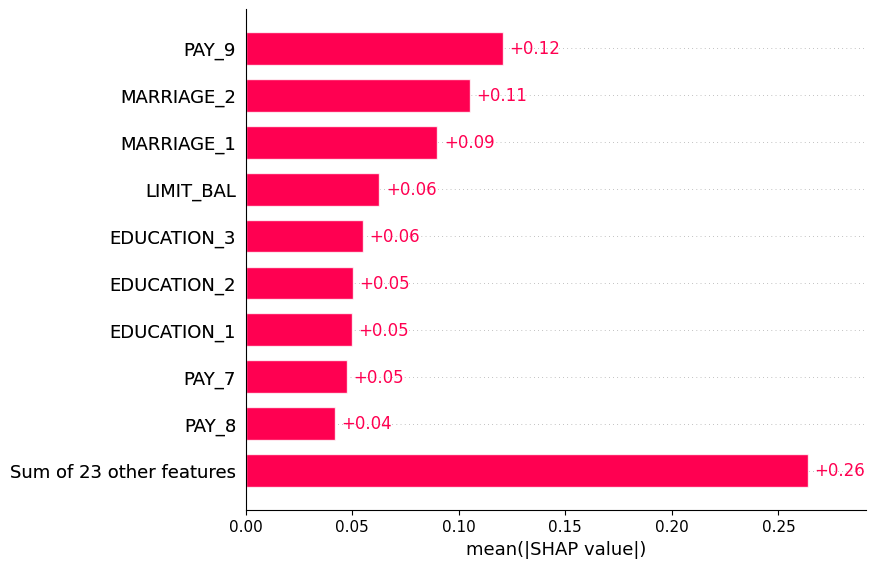

In [131]:
shap.plots.bar(shap_values)

### LIME

#### local explanation with lime

157/157 [==============================] - 2s 9ms/step


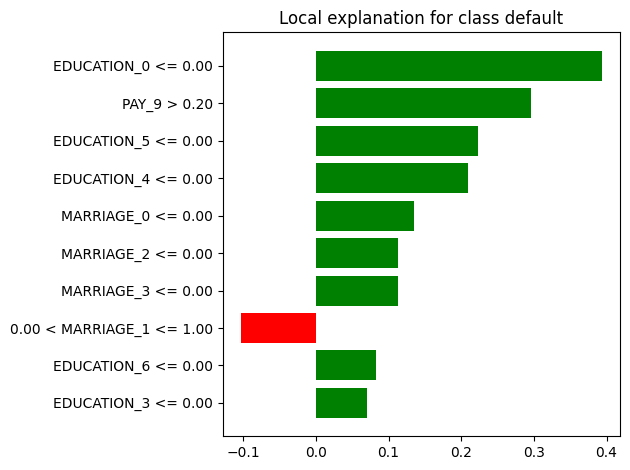

In [134]:
# Test LIME on Isolation Forest to check why it performs that bad
from lime import lime_tabular
from lime import lime_image

# Define the tabular lime explainer
explainer = lime_tabular.LimeTabularExplainer(training_data=X_test.values,
    feature_names=X_test.columns,
    class_names=['did not default', 'default'],
    mode='classification')

# Try to explain a prediction on a sample
n_features = 10
exp = explainer.explain_instance(predict_fn=final_model.predict_proba, data_row=X_test.iloc[row_selected], num_features=n_features)

# Plot the Local explanation for class default
exp.show_in_notebook()
exp.as_pyplot_figure()
plt.tight_layout()


### Permutation feature importance

In [94]:

r = permutation_importance(final_model, X_test.iloc[:1000], y_test.iloc[:1000], n_repeats=30, random_state=42, scoring="f1")

32/32 [==============================] - 0s 9ms/step


In [91]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

PAY_9   0.108 +/- 0.013
MARRIAGE_20.052 +/- 0.009
MARRIAGE_10.043 +/- 0.010
EDUCATION_10.041 +/- 0.008
EDUCATION_20.026 +/- 0.007
LIMIT_BAL0.023 +/- 0.009
PAY_7   0.022 +/- 0.010
EDUCATION_30.021 +/- 0.005
EDUCATION_40.003 +/- 0.001


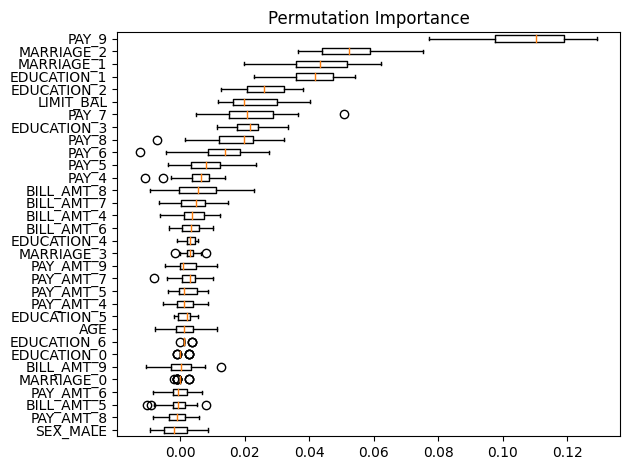

In [92]:
fig, ax = plt.subplots()
sorted_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()